<a href="https://colab.research.google.com/github/jt-ut/GaiaREU/blob/main/GaiaREU-ML_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to REU's ML Workshop

Intro

Workflow: Exploratory Data Analysis, Unsupervised vs. Supervised ML

Data Description: Gaia XpSampledMeanSpectrum, briefly discuss pre-processing (unit normalization)

In [57]:
## Install additional Python packages
!pip install umap-learn yellowbrick

## Import required modules
# For data wrangling
import pandas as pd
import numpy as np
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Dimensionality Reduction & Testing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
#from sklearn.neighbors import KDTree
from sklearn.manifold import trustworthiness
# Clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans



# Exploratory Gaia Analysis with Unsupervised Machine Learning

In [11]:
# Read data from web
flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_flux.csv', header=None)
wvl = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_wvl.csv', header=None)[0]

# Inspect the downloaded data
print(flux.shape)
print(flux.iloc[0])

print(wvl.shape)
print(wvl)

(3981, 343)
0      0.157631
1      0.140994
2      0.124082
3      0.120104
4      0.125592
         ...   
338    0.004656
339    0.004211
340    0.004113
341    0.004181
342    0.004694
Name: 0, Length: 343, dtype: float64
(343,)
0        1
1        2
2        3
3        4
4        5
      ... 
338    339
339    340
340    341
341    342
342    343
Name: 0, Length: 343, dtype: int64


Our flux data is arranged into a 3,981 row $\times$ 343 column ***data matrix***.

Each row represents an individual source (emitter of light) in the Gaia archive, and each column holds the flux measurements of that source at the 343 different wavelengths stored in the $wvl$ vector. Our data is actually flux from a model fit (not the actual observation) measured at 343 *pseudo*-wavelengths, represented by the sequential integers in the wvl vector.

FYI, almost all statistical and machine learning algorithms expect a data matrix arranged as above, with ***observations*** contained in its rows and ***variable measurements*** in its columns.

Let's plot some of our flux data just to get an idea of what these 343-dimensional vectors might look like.

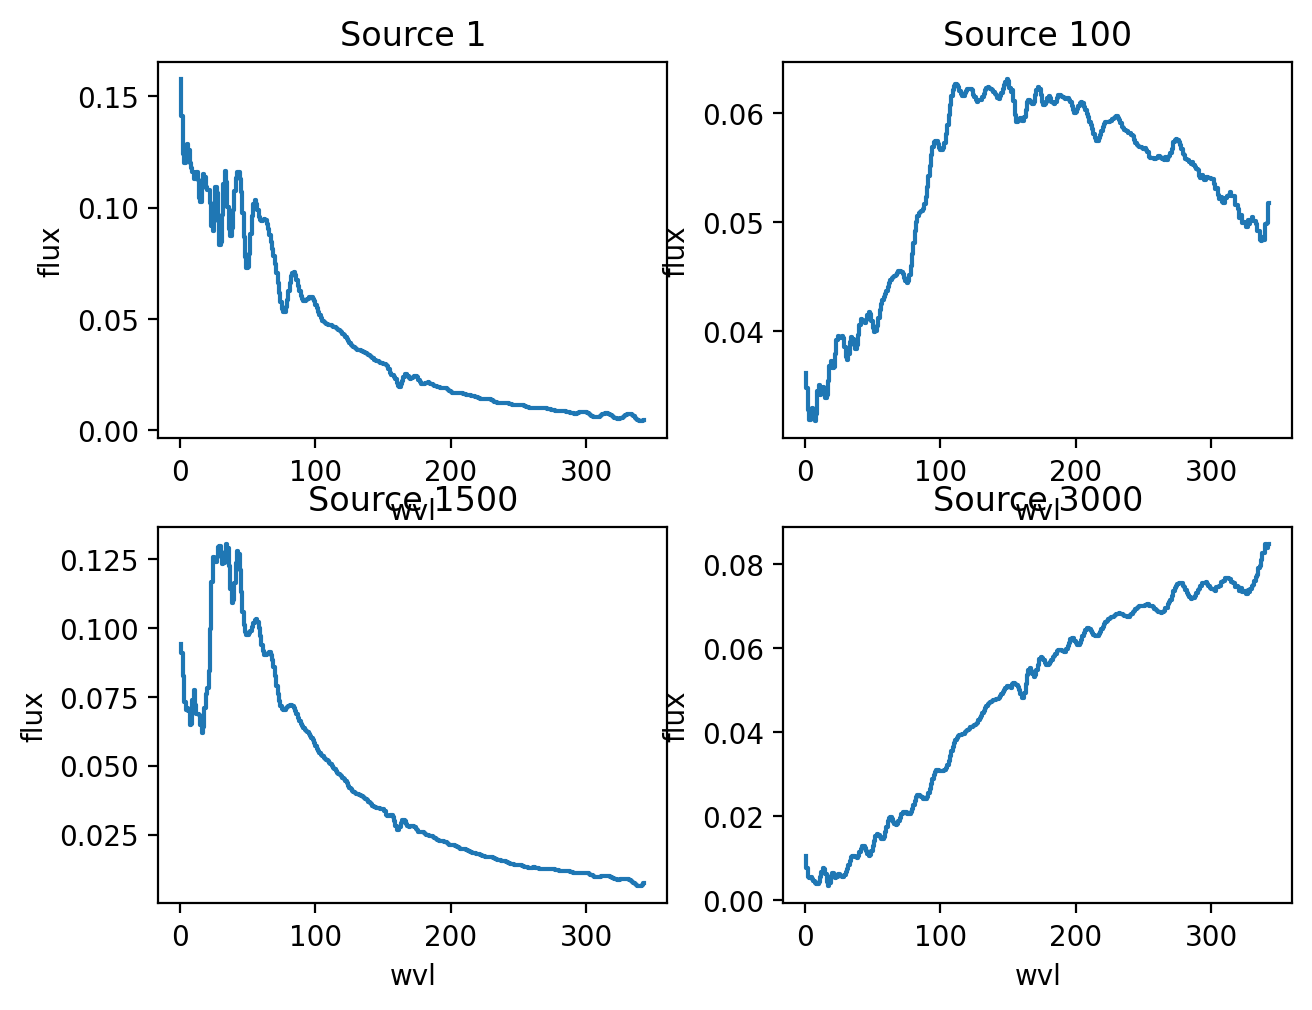

In [12]:
# Plot a few source spectra
plt.rcParams['figure.dpi'] = 200
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[0]}), drawstyle='steps-pre', ax=axes[0,0]).set(title='Source 1')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[99]}), drawstyle='steps-pre', ax=axes[0,1]).set(title='Source 100')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[1499]}), drawstyle='steps-pre', ax=axes[1,0]).set(title='Source 1500')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[2999]}), drawstyle='steps-pre', ax=axes[1,1]).set(title='Source 3000')
plt.show()

What we have just done, plotting actual data vectors in their native space, is called ***data visualiation***. Visualizing your data is probably the easiest, and most intuitive, part of ***exploratory data analysis***, which allows us to get a crude summary of what's "going on" in our data. For example, our plots above indicate that the sources in our sample have drastically different spectral profiles.


##Dimensionality Reduction

But does each source have a (meaningfully) different spectra, or could there be groups of sources with similar spectra? Since we can't realistically visualize the 343-dim spectra of all 3,000+ sources in our sample, we will instead build a *representation* of our data and visualize that. *Dimensionality Reduction* is the process of representing high-dimensional data in a lower dimensional space, usually 2-d or 3-d, for easy visualization. This is also called ***embedding*** our data.

There are many DR algorithms in statistics and machine learning. We introduce a few of the most common below:

### PCA

No parameters

### t-SNE

t-distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) attempts to place points in low-dimensional space such that similarities among their $k$-nearest high-dimensional neighbors are preserved. $k$ is a user-supplied parameter that t-SNE calls *perplexity*. t-SNE defines point-wise similarity as a (Gaussian) function of distance, and minimizes [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to bring low-dim point similarites in line with their high-dim counterparts.

### UMAP

Uniform Manifold Approximation & Projection ([UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)) is built upon the same idea as t-SNE, except it defines its high-dim and low-dim similarities differently (but still as a function of distance), and then attempts to find low-dim points which minimize the [Cross-Entropy](https://en.wikipedia.org/wiki/Cross_entropy) between themselves and their high-dim counterparts. UMAP also needs a user-supplied parameter it calls *n_neighbors*, which controls how many point-wise similarities should be preserved in low-dim.

Let's perform Dimensionality Reduction on our flux data and see how each of the above algorithms places our points in a plane.

In [ ]:
## PCA, no parameters needed!
X_pca = PCA(n_components=2).fit_transform(flux)
X_pca = pd.DataFrame(X_pca, columns = ['x','y'])

## t-SNE, using default perplexity = 30
X_tsne = TSNE(n_components=2, perplexity=30.0, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne = pd.DataFrame(X_tsne, columns = ['x','y'])

## UMAP, using its default n_neighbors = 15
X_umap = UMAP(n_neighbors=15, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap = pd.DataFrame(X_umap, columns = ['x','y'])

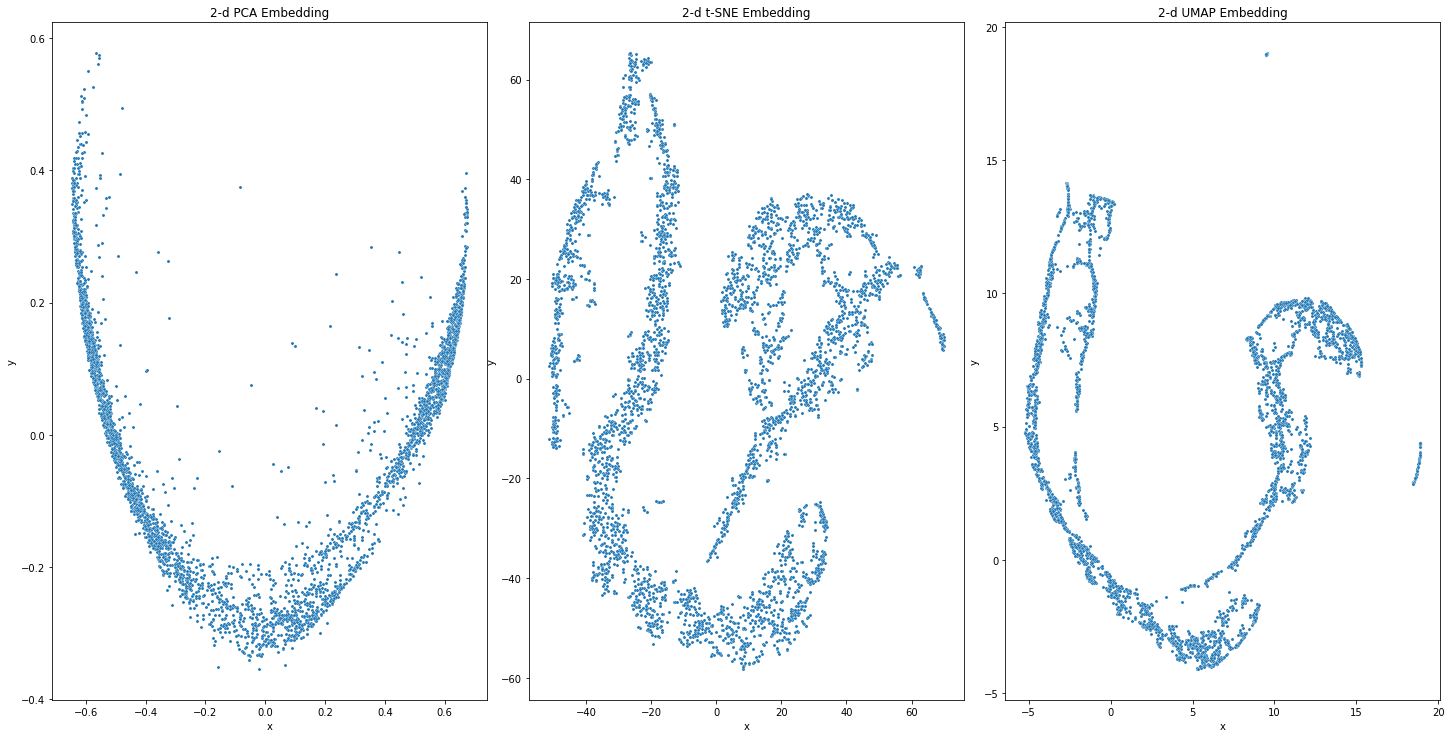

In [17]:
## Visualize the PCA, t-SNE, and UMAP representations of our flux data
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = X_pca, s=10, ax=axes[0]).set(title='2-d PCA Embedding')
sns.scatterplot(x='x', y='y', data = X_tsne, s=10, ax=axes[1]).set(title='2-d t-SNE Embedding')
sns.scatterplot(x='x', y='y', data = X_umap, s=10, ax=axes[2]).set(title='2-d UMAP Embedding')
plt.show()

Based on these representations, does our data appear to be completely random, or does it have any meaningful ***structure***?

Based on how PCA, t-SNE, and UMAP work, what do you think any 2-d structure visible in the above might suggest about our 343-d flux data?

## Kernel Smoothing

It is usually hard, and generally a bad idea, to draw too many conclusions about your dataset by scrutinizing individual points.  This is because almost all real-world datasets contain ***noise***, and when you pick a few points at random from your sample you cannot be reasonably certain whether they are, or are not, noise.

The field of statistics offers many tools to help us "see" signals despite the presence of noise. One of these is called ***kernel smoothing***, or ***kernel density estimation***. The idea is to build a smoothed representation of the ***data density*** (number of points in a fixed area / volume) from which we can draw conclusions about our data.

Let's see what a smoothed version of our DR visualizations looks like.

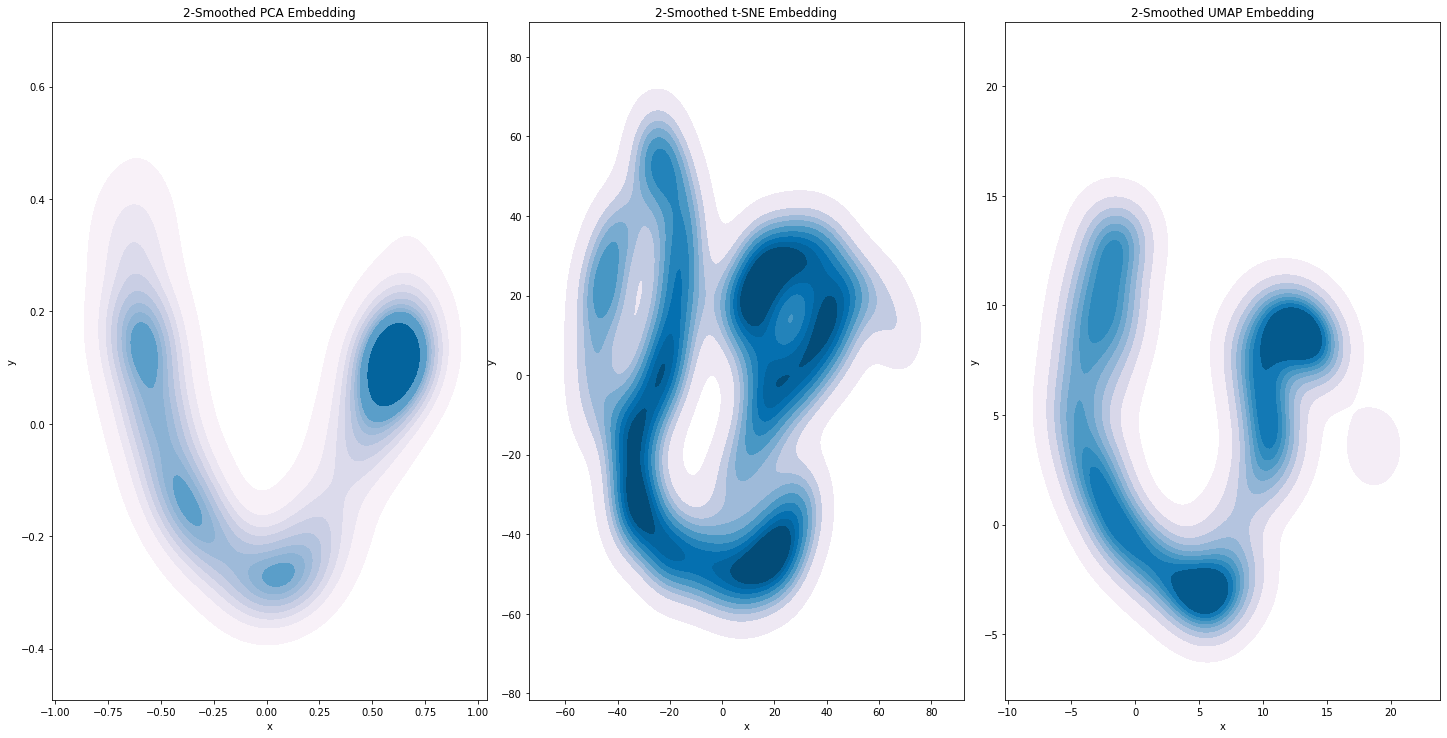

In [20]:
## Smoother visualizations of our embedded flux data
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.kdeplot(data=X_pca, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0]).set(title='2-Smoothed PCA Embedding')
sns.kdeplot(data=X_tsne, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1]).set(title='2-Smoothed t-SNE Embedding')
sns.kdeplot(data=X_umap, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[2]).set(title='2-Smoothed UMAP Embedding')
plt.show()

Darker colors in the above heatmaps represent areas of higher data density, meaning more points are packed more tightly in these regions.

Do you see more structure than in the scatterplots we made above? Is it easier to see?

## DR Parameterization

Recall that both t-SNE and UMAP have a parameter controlling how many high-dim neighbors they attempt to preserve in low-dim. t-SNE calls this perplexity, which left at its default = 30, and UMAP calls this n_neighbors, which we left at its default = 15.

Let's change these parameters, setting them both lower and higher than their default, to see how this affects the representation of our flux data.

In [27]:
## Supply a perplexity < 30, and a n_neighbors < 15
lo_perplexity = 10
lo_n_neighbors = 5
# Supply a perplexity > 30, and a n_neighbors > 15
hi_perplexity = 50
hi_n_neighbors = 25

## Re-run both t-SNE & UMAP at the low and high parameter values
X_tsne_lo = TSNE(n_components=2, perplexity=lo_perplexity, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne_lo = pd.DataFrame(X_tsne_lo, columns = ['x','y'])

X_umap_lo = UMAP(n_neighbors=lo_n_neighbors, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap_lo = pd.DataFrame(X_umap_lo, columns = ['x','y'])

X_tsne_hi = TSNE(n_components=2, perplexity=hi_perplexity, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne_hi = pd.DataFrame(X_tsne_hi, columns = ['x','y'])

X_umap_hi = UMAP(n_neighbors=hi_n_neighbors, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap_hi = pd.DataFrame(X_umap_hi, columns = ['x','y'])

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3981 samples in 0.009s...
[t-SNE] Computed neighbors for 3981 samples in 0.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3981
[t-SNE] Computed conditional probabilities for sample 2000 / 3981
[t-SNE] Computed conditional probabilities for sample 3000 / 3981
[t-SNE] Computed conditional probabilities for sample 3981 / 3981
[t-SNE] Mean sigma: 0.015510
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.560287
[t-SNE] KL divergence after 1000 iterations: 1.040796
UMAP(n_jobs=2, n_neighbors=5, random_state=123, verbose=True)
Fri Jun 30 13:09:57 2023 Construct fuzzy simplicial set
Fri Jun 30 13:10:12 2023 Finding Nearest Neighbors
Fri Jun 30 13:10:15 2023 Finished Nearest Neighbor Search
Fri Jun 30 13:10:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jun 30 13:10:25 2023 Finished embedding
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3981 samples in 0.032s...
[t-SNE] Computed neighbors for 3981 samples in 2.510s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3981
[t-SNE] Computed conditional probabilities for sample 2000 / 3981
[t-SNE] Computed conditional probabilities for sample 3000 / 3981
[t-SNE] Computed conditional probabilities for sample 3981 / 3981
[t-SNE] Mean sigma: 0.027153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.406448
[t-SNE] KL divergence after 1000 iterations: 0.638342
UMAP(n_jobs=2, n_neighbors=25, random_state=123, verbose=True)
Fri Jun 30 13:12:06 2023 Construct fuzzy simplicial set
Fri Jun 30 13:12:26 2023 Finding Nearest Neighbors
Fri Jun 30 13:12:27 2023 Finished Nearest Neighbor Search
Fri Jun 30 13:12:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jun 30 13:12:39 2023 Finished embedding


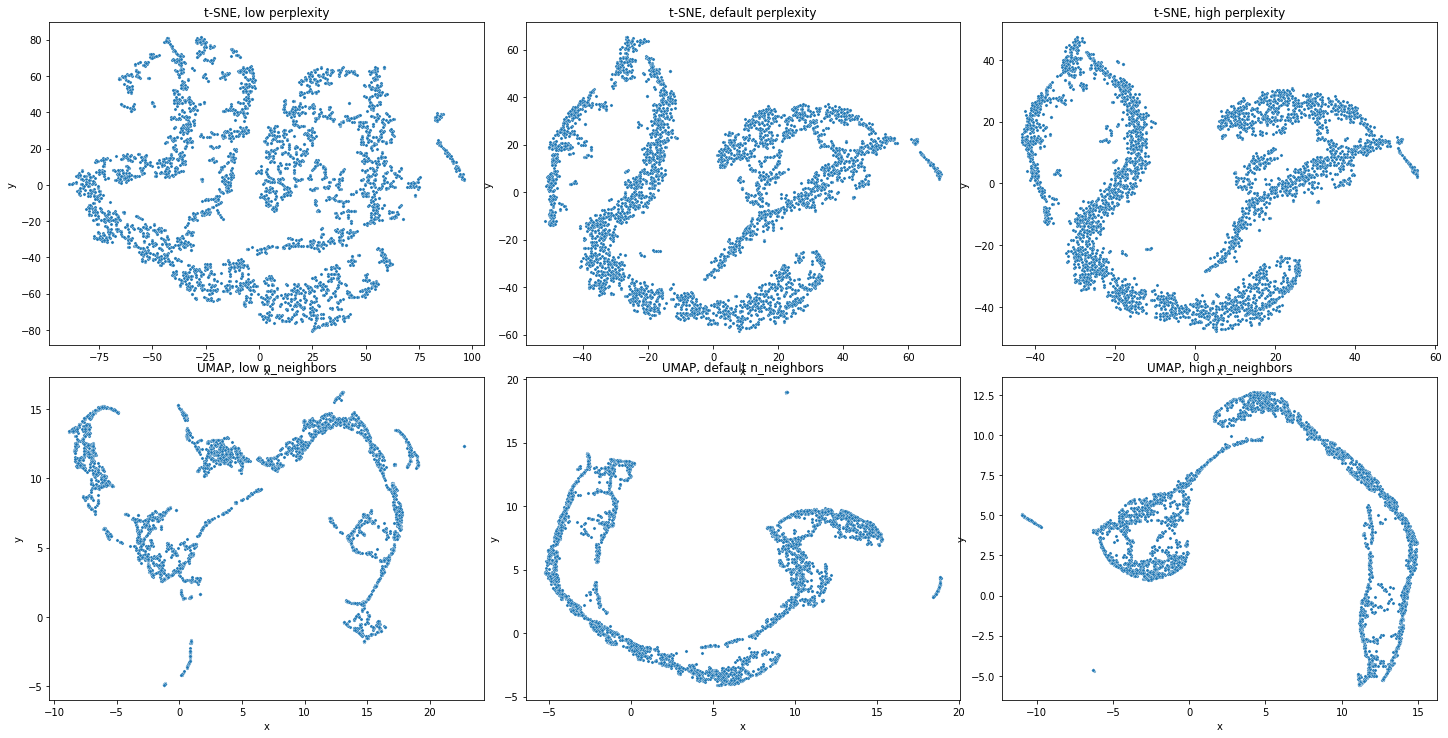

In [28]:
## Visualize the original parameterizations along with their lo and hi counterparts
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(2, 3)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = X_tsne_lo, s=10, ax=axes[0][0]).set(title='t-SNE, low perplexity')
sns.scatterplot(x='x', y='y', data = X_tsne, s=10, ax=axes[0][1]).set(title='t-SNE, default perplexity')
sns.scatterplot(x='x', y='y', data = X_tsne_hi, s=10, ax=axes[0][2]).set(title='t-SNE, high perplexity')
sns.scatterplot(x='x', y='y', data = X_umap_lo, s=10, ax=axes[1][0]).set(title='UMAP, low n_neighbors')
sns.scatterplot(x='x', y='y', data = X_umap, s=10, ax=axes[1][1]).set(title='UMAP, default n_neighbors')
sns.scatterplot(x='x', y='y', data = X_umap_hi, s=10, ax=axes[1][2]).set(title='UMAP, high n_neighbors')
plt.show()

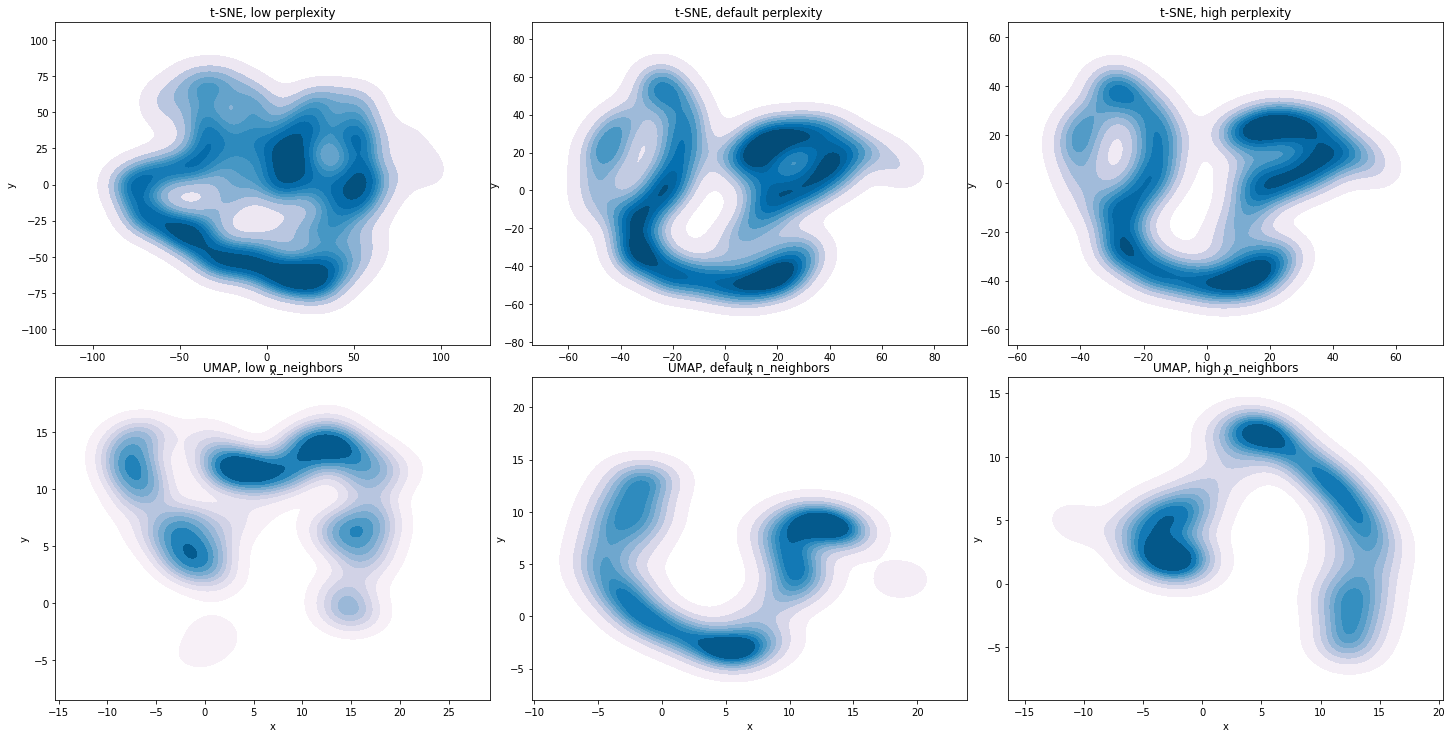

In [30]:
## Smoothed versions of the above
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(2, 3)
fig.tight_layout()
sns.kdeplot(data=X_tsne_lo, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][0]).set(title='t-SNE, low perplexity')
sns.kdeplot(data=X_tsne, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][1]).set(title='t-SNE, default perplexity')
sns.kdeplot(data=X_tsne_hi, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][2]).set(title='t-SNE, high perplexity')
sns.kdeplot(data=X_umap_lo, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][0]).set(title='UMAP, low n_neighbors')
sns.kdeplot(data=X_umap, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][1]).set(title='UMAP, default n_neighbors')
sns.kdeplot(data=X_umap_hi, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][2]).set(title='UMAP, high n_neighbors')
plt.show()

Does your assessment of how much structure is our data change with different parameterizations?

If so, how?

How do we determine which of the above representations is best?

## Assessing DR Embeddings

It is recommended by the authors of both the t-SNE and UMAP algorithms to produce multiple DRs using various values of the perplexity / n_neighbors parameter, just as we did above. Sadly, their recommendations are silent on how to pick the best among these many candidate embeddings, because what is "best" changes with every dataset you will encounter.

This is a frustrating circular issue in all Unsupervised Machine Learning. In order to assess how good your learning is, you must first know what you're trying to learn.

One way of breaking this circular problem is to ask how well our algorithms performed, relative to what they were *trying* to achieve. For t-SNE and UMAP, that means comparing the high-dim neighbors to low-dim counterparts.

scikit-learn has a built-in [trustworthiness](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html) function that does this, which reports the proportion of high-d $k$-nearest neighborhoods which are preserved in a low-d embedding. Thus, a trustworthiness value is in the range $[0,1]$, with 0 meaning NONE of the neighbor relationsips are preserved (bad), and 1 meaning ALL neighbor relationships are preserved (good).

Since we don't know the "right" $k$ to consider here, we will compute the trustworthiness over values in the range of $k$ we specified above, and see how each method performs overall.

[Text(0.5, 1.0, 'Trustworthiness of Flux Embeddings')]

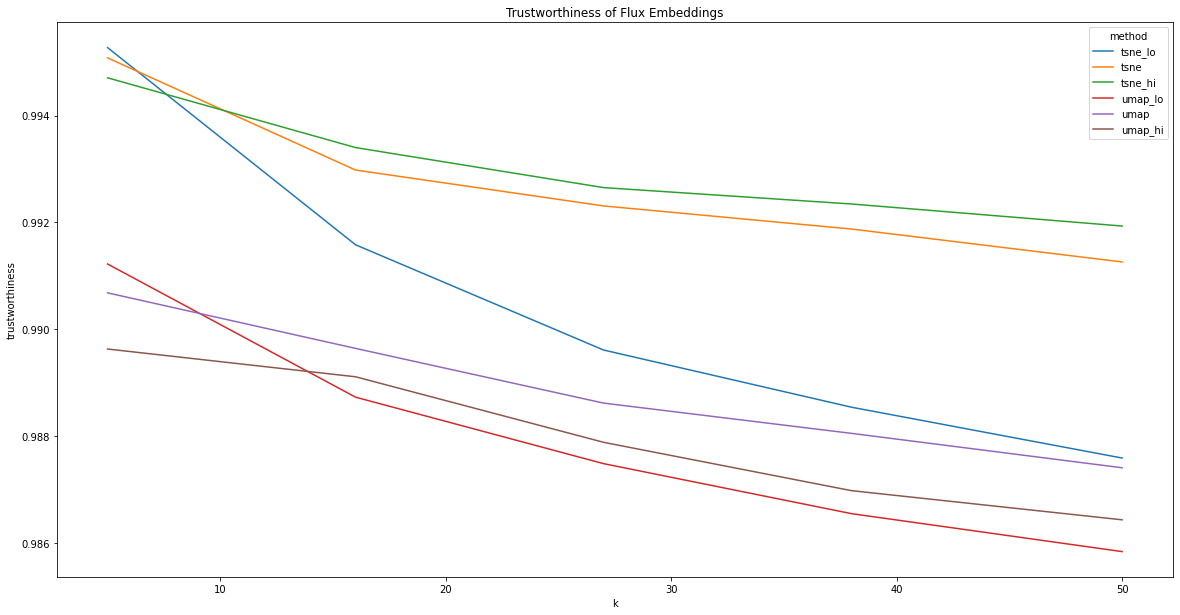

In [54]:
## Define a grid of evenly spaced
k_grid = np.linspace(start=min(lo_perplexity, lo_n_neighbors), stop=max(hi_perplexity, hi_n_neighbors), num = 5).astype('int')
## Compute trustworthiness for each method, at each value of k in our range
trust = pd.DataFrame(columns = ['method','k','trustworthiness'])
for k in k_grid:
  trust.loc[len(trust)] = ['tsne_lo', k, trustworthiness(X=flux, X_embedded=X_tsne_lo, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['tsne', k, trustworthiness(X=flux, X_embedded=X_tsne, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['tsne_hi', k, trustworthiness(X=flux, X_embedded=X_tsne_hi, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap_lo', k, trustworthiness(X=flux, X_embedded=X_umap_lo, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap', k, trustworthiness(X=flux, X_embedded=X_umap, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap_hi', k, trustworthiness(X=flux, X_embedded=X_umap_hi, n_neighbors=k, metric='euclidean')]

## Plot results
plt.rcParams['figure.figsize'] = (10,10)
sns.lineplot(x='k', y='trustworthiness', data=trust, hue='method').set(title='Trustworthiness of Flux Embeddings')


Which method appears to represents **most** $k$-nearest neighborhoods best?

Let's save the $(x,y)$ values of your favorite embedding in the new data frame **X_best**:

In [55]:
## Uncomment the line corresponding to your favorite embedding, and run this cell.
## Later, we will use your favorite embedding to visualize more information learned from Gaia

#X_best = X_tsne_lo
#X_best = X_tsne
X_best = X_tsne_hi
#X_best = X_umap_lo
#X_best = X_umap
#X_best = X_umap_hi

# Clustering

The most common technique in Unsupervised Machine Learning is called [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), which partitions a dataset into $C$ groups of "similar items." This is a more formal process that mimics what you were doing by eye above when we tried to find structure in our embedded data.

As you might suspect, there is no universally applicable definition of what it means for two points to be "similar". Because each clustering algorithm differs in how they define point-wise similarities, there is also (sadly) no universally "best" clustering algorithm. Just like in DR analysis, we usually have to try several different algorithms with different parameterizations, and use external knowledge or assumptions about the domain which generated our data (here, astronomy).

Although there are [many](https://scikit-learn.org/stable/modules/clustering.html) algorithms to choose from, we will partition our Gaia flux data using  [K-Means](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.), which is one of the oldest and simplest clustering methods out there. Despite its age and simplicity, K-Means is still widely used in practice, partly because we understand everything about it and partly because it's fast.  

K-Means only has one parameter, $K$, which tells the algorithm how many groups to find in the data. Once you supply $K$, the algorithm returns to you $K$ group centroids (means) which are closest to most of the data. All data that are closer to centroid $i$ than any other centroid are assigned to group (or cluster) $i$, etc.

To get a feel for how this works, let's ask K-Means to partition our Gaia flux data into 5 groups, and look at how those groups are split on the favorite embedding you selected above.  

In [58]:
## Run K-Means Clustering with K=5 groups
#  Calling KMeans returns an integer vector, length = nrows(flux),
#  which contains the cluster label for each Gaia source
X_best['KMCluster'] = KMeans(n_clusters=5, random_state=123).fit(flux).labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[Text(0.5, 1.0, 'K-Means Clustering, K=5')]

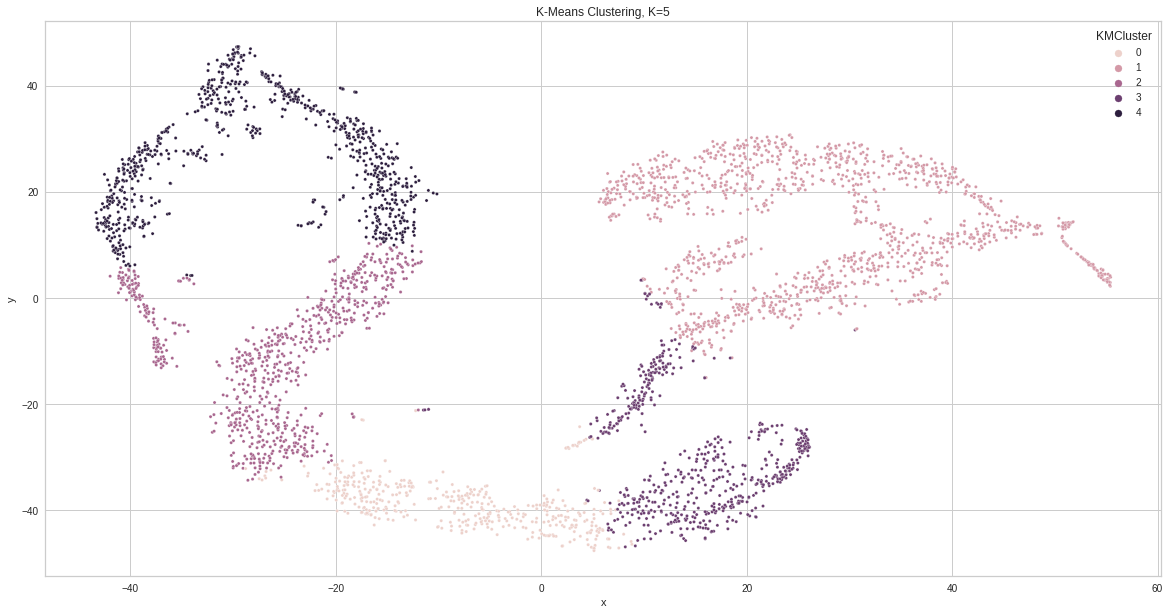

In [62]:
plt.rcParams['figure.figsize'] = (20,10)
sns.scatterplot(x='x', y='y', hue='KMCluster', data = X_best, s=10).set(title='K-Means Clustering, K=5')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

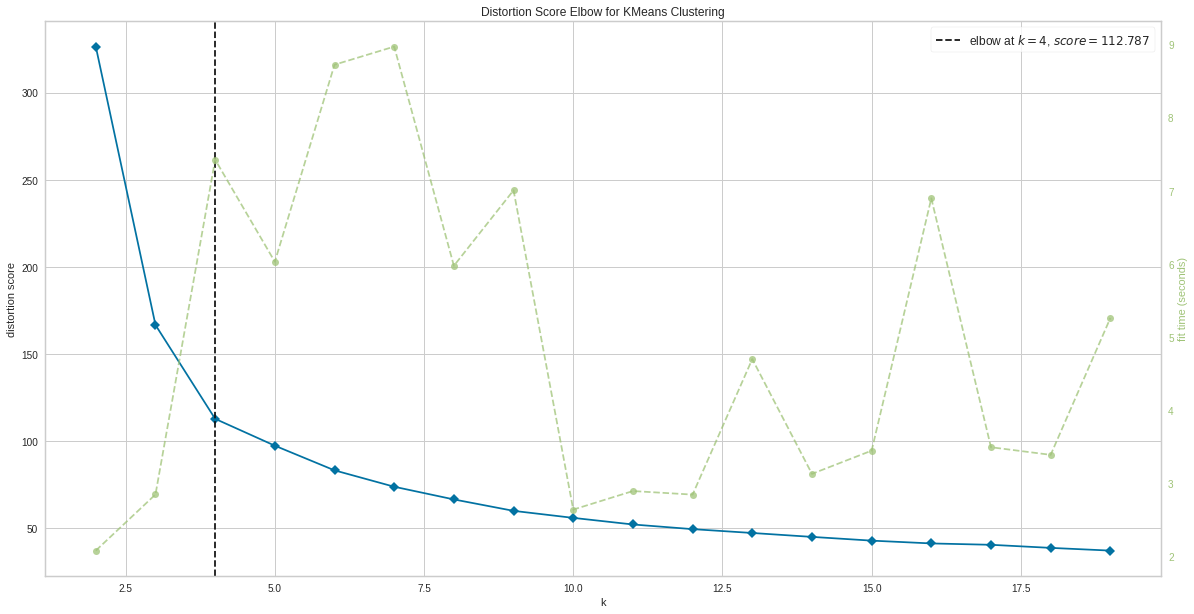

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
## Knee Plot
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), metric = 'distortion', timings= True)
visualizer.fit(flux)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure